In [1]:
import numpy as np
import scipy
from scipy.stats import multivariate_normal
import wfdb

from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def awgn(sig, snr_db):
    """
    add white gaussian noise to the signal
    snr_db: signal to noise ratio (in dB)
    """
    sig_p = np.mean(sig**2)
    snr = 10 ** (snr_db / 10)  # dB = 10 log_10 (x)
    noise_p = sig_p / snr
    noise = np.random.normal(0, np.sqrt(noise_p), sig.shape)
    return sig + noise

In [3]:
def make_Pi(i, P, N):
    """
    make_Pi(i, P, N) @ z extracts [z_i, z_i+1, ..., z_i+P-1] where len(z) = N
    """
    mat = np.zeros((P, N))
    for j in range(P):
        mat[j, (i+j)%N] = 1
    return mat

In [4]:
def get_patches(sig, P):
    """
    return list of all overlapping patches of length P each from sig
    """
    N = len(sig)
    patches = []
    for i in range(N):
        patches.append(make_Pi(i, P, N) @ sig)
    return patches


In [5]:
def calc_snr(clean, noisy):
    """
    compute signal to noise ratio of `noisy` wrt `clean`
    """
    return 10*np.log10(np.sum(clean ** 2)/np.sum((noisy - clean)**2))

In [6]:
rec104 = wfdb.rdrecord("data/mit-bih-arrhythmia-database-1.0.0/104")
rec105 = wfdb.rdrecord("data/mit-bih-arrhythmia-database-1.0.0/105")
rec115 = wfdb.rdrecord("data/mit-bih-arrhythmia-database-1.0.0/115")


In [7]:
P = 30
patchset104 = get_patches(rec104.p_signal[:10800, 1], P=P)

In [8]:
K = 10
gmm = GaussianMixture(n_components=K)
gmm.fit(patchset104)


GaussianMixture(n_components=10)

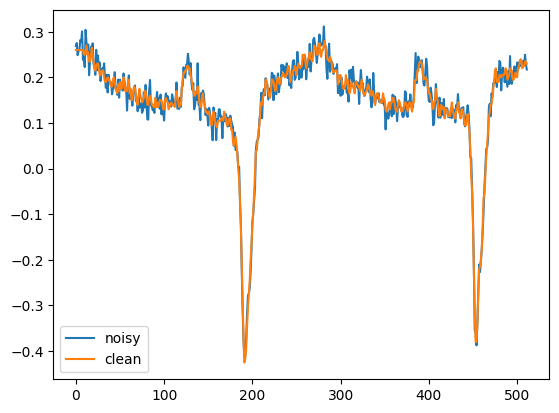

In [9]:
N = 512
ST = 0
ET = ST+N
sig = rec105.p_signal[ST:ET, 1]
sign = awgn(sig, 20)
plt.plot(range(ST, ET), sign, label="noisy")
plt.plot(range(ST, ET), sig, label="clean")
plt.legend()


In [86]:
sigma2 = 1e-4
Pis = [make_Pi(i, P, N) for i in range(N)]
Cov1 = [gmm.covariances_[j] + sigma2 * np.eye(P) for j in range(K)]
Cs = [gmm.covariances_[j] @ np.linalg.inv(Cov1[j]) for j in range(K)]
alphas = gmm.weights_
Nos = [multivariate_normal(mean=mu, cov=sigma).pdf for mu, sigma in zip(gmm.means_, Cov1)]
def Beta(j, u):
    return (alphas[j] * Nos[j](u))/sum((alphas[l] * Nos[l](u)) for l in range(K))
def G(u):
    """
    denoise a single patch
    """
    denom = sum((alphas[l] * Nos[l](u)) for l in range(K))
    return sum(((alphas[j] * Nos[j](u)) * Cs[j]) for j in range(K)) @ u/denom
def D(z):
    """
    gmm-denoise the signal
    """
    return 1/P * sum(Pis[i].T @ G(Pis[i] @ z) for i in range(N))

In [87]:
u = Pis[5] @ sig

In [88]:
%timeit D(sig)

279 ms ± 16.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [89]:
0.353 * 512

180.736

In [90]:
res = D(D(sign))

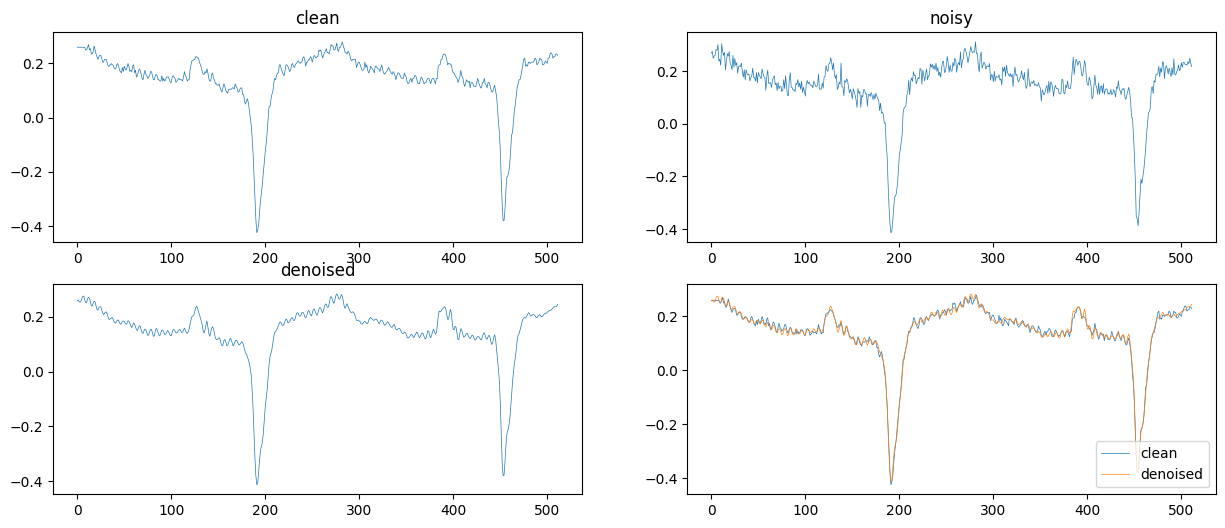

In [91]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.set_size_inches(15, 6)
ax1.plot(range(ST, ET), sig, linewidth=0.5)
ax1.set_title("clean")
ax2.plot(range(ST, ET), sign, linewidth=0.5)
ax2.set_title("noisy")
ax3.plot(range(ST, ET), res, linewidth=0.5)
ax3.set_title("denoised")
ax4.plot(range(ST, ET), sig, label="clean", linewidth=0.5)
ax4.plot(range(ST, ET), res, label="denoised", linewidth=0.5)
ax4.legend(loc="lower right")

In [92]:
calc_snr(sig, sign)

20.156090741665473

In [93]:
calc_snr(sig, res)

25.378154218821752

In [94]:
def make_phi(M, N):
    """
    generate random orthonormal measurement matrix for compressive sensing
    """
    phi = np.random.normal(0, 1, (M, N))
    phi = scipy.linalg.orth(phi.T).T
    return phi

In [95]:
CR = 0.50
M = int((1-CR) * N)
PHI = make_phi(M, N)

In [96]:
y = PHI @ sig
y = awgn(y, snr_db=20)

In [103]:
ITERS = 150
LR = 0.3
SWITCH_T = 20
x = np.zeros(N)

A = np.eye(N) - LR * PHI.T @ PHI
B = LR * PHI.T @ y
denoiser = D

# PnP - PGD
for T in range(ITERS):
    x = denoiser(A @ x + B)  
    if T == SWITCH_T:
        W = 1/P * sum(Pis[i].T @ (sum(Beta(j, Pis[i] @ x) * Cs[j] for j in range(K))) @ Pis[i] for i in range(N))
        denoiser = lambda z: W @ z



In [104]:
Beta(5, Pis[5] @ x).shape

()

In [105]:
calc_snr(sig, x)

20.279826994495266

In [106]:
# plt.plot(loss_hist)

Text(0.5, 0, 'snr = 20.28')

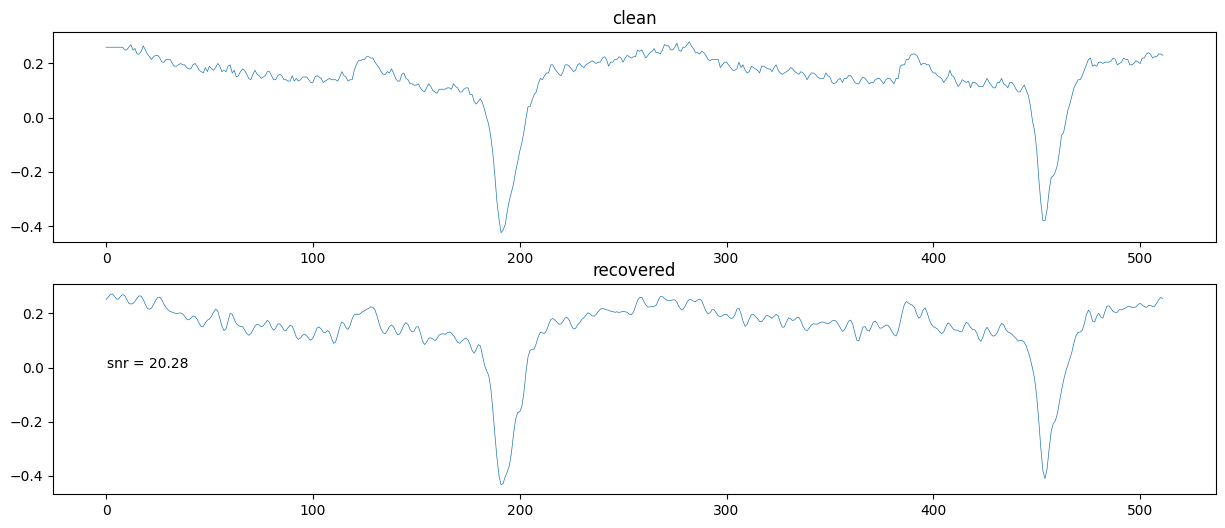

In [107]:
fig, (ax1, ax2) = plt.subplots(2)
fig.set_size_inches(15, 6)
ax1.plot(range(ST, ET), sig, linewidth=0.5)
ax1.set_title("clean")
ax2.plot(range(ST, ET), x, linewidth=0.5)
ax2.set_title("recovered")
ax2.text(0.5, 0, f"snr = {calc_snr(sig, x):.2f}")

In [108]:
%timeit D(x)

292 ms ± 51.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
